# 0) Setup: paths & imports

We’ll test the new `hybrid.io` API on your real file:

``data/shorts/MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff``

We’ll also create an output folder for any artifacts written during the test.


In [1]:
from pathlib import Path
import numpy as np

from hybrid.io import (
    read_tiff_stack, read_tiff_memmap, iter_tiff_blocks,
    write_tiff_stack, TiffStreamWriter
)

DATA_DIR = Path("data/shorts")
BASENAME = "MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff"
SRC = (DATA_DIR / BASENAME).resolve()

OUT = Path("io_smoketest_real")
OUT.mkdir(exist_ok=True, parents=True)

print("Source file:", SRC)


Source file: D:\Projects\hybrid\notebooks\data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff


# 1) Read via memmap (fast path)

Try `read_tiff_memmap(...)`. Some TIFFs (compressed/tiling/non-contiguous series) cannot be memory-mapped — we’ll handle that gracefully and report the reason.


In [2]:
mm = None
try:
    mm = read_tiff_memmap(SRC.as_posix(), as_TYX=True)
    print("memmap OK:", type(mm), mm.shape, mm.dtype)
    if mm.ndim == 3:
        print("Frame 0 stats — mean/std:", float(mm[0].mean()), float(mm[0].std()))
except Exception as e:
    print("memmap failed:", type(e).__name__, str(e))


memmap failed: ValueError TIFF has multiple pages but no contiguous stack series.


# 2) Read via full-RAM imread (raw and percentile-normalized)

Use `read_tiff_stack(method="imread")` to force loading into RAM.

- **Raw** (`normalize_mode="none"`)
- **Percentile-normalized** (`normalize_mode="percentile"`, by default uses `p_low=1`, `p_high=99.9`)  
  We’ll set `p_low=1.0`, `p_high=99.0` explicitly here.


In [3]:
arr_raw = read_tiff_stack(
    SRC.as_posix(),
    method="imread",
    normalize_mode="none",
    verbose=False
)
print("imread (raw):", arr_raw.shape, arr_raw.dtype,
      "min/max:", float(arr_raw.min()), float(arr_raw.max()))

arr_norm = read_tiff_stack(
    SRC.as_posix(),
    method="imread",
    normalize_mode="percentile",
    p_low=1.0, p_high=99.0,
    verbose=False
)
print("imread (percentile norm):", arr_norm.shape, arr_norm.dtype,
      "min/max:", float(arr_norm.min()), float(arr_norm.max()))


imread (raw): (300, 800, 768) uint16 min/max: 475.0 3303.0
imread (percentile norm): (300, 800, 768) float32 min/max: 0.0 1.0


# 3) Auto strategy with RAM guard

Call `read_tiff_stack(method="auto")`. This prefers memmap when possible, otherwise chooses between in-RAM read or staging based on `ram_budget_bytes`.

We set a small guard to demonstrate the parameter (it won’t block memmap; it only applies to non-memmap paths).


In [4]:
arr_auto = read_tiff_stack(
    SRC.as_posix(),
    method="auto",
    ram_budget_bytes=64 * 1024 * 1024,  # 64 MiB
    normalize_mode="none",
    verbose=True
)
print("auto:", type(arr_auto), arr_auto.shape, arr_auto.dtype)


[I/O] Using full-RAM imread (~0.34 GiB): D:\Projects\hybrid\notebooks\data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.tiff
auto: <class 'numpy.ndarray'> (300, 800, 768) uint16


# 4) Force the staging path (disk-backed memmap)

Use `method="auto_stage"` to exercise the staging path. The code will create a `.staged.<dtype>.dat` file next to the chosen stage directory and return a memmap backed by that file.


In [5]:
arr_staged = read_tiff_stack(
    SRC.as_posix(),
    method="auto_stage",
    stage_block=32,  # arbitrary block size to exercise the loop
    verbose=True
)
print("staged:", type(arr_staged), arr_staged.shape, arr_staged.dtype)

# Compare to either memmap (if available) or the raw imread array
ref = mm if mm is not None else arr_raw
print("staged equals reference (allclose):", np.allclose(np.asarray(arr_staged), np.asarray(ref)))


[I/O] Staging to disk memmap (~0.34 GiB): D:\Projects\hybrid\notebooks\data\shorts\MoS1b_s3_C1_M3_T3_TRE_2025_04_08_clip_000825-001125.staged.uint16.dat
  staged 128/300 frames
  staged 256/300 frames
  staged 300/300 frames
staged: <class 'numpy.ndarray'> (300, 800, 768) uint16
staged equals reference (allclose): True


# 5) Stream in temporal blocks with halo

Demonstrate `iter_tiff_blocks(...)` by reconstructing the full stack from blocks with a temporal halo. We then check equality with a reference array.


In [6]:
# Choose a reference (prefer memmap; else use arr_raw)
ref = mm if mm is not None else arr_raw
T = ref.shape[0]
recon = np.empty_like(ref)

block, halo = 20, 3
for start, end, blk in iter_tiff_blocks(SRC.as_posix(), block=block, halo=halo, as_TYX=True):
    # blk includes halo; core slice is [start:end)
    left_halo = halo if start > 0 else 0
    core = blk[left_halo:left_halo + (end - start)]
    recon[start:end] = core

print("Reconstructed equals reference:", np.allclose(np.asarray(recon), np.asarray(ref)))


Reconstructed equals reference: True


# 6) Streaming writer: append frames one-by-one

Use `TiffStreamWriter` to write a new TIFF by appending individual frames, then read it back and verify the data.


In [7]:
STREAM_DST = OUT / "stream_written_from_source.tiff"

# Use the reference stack for writing (avoids double-decoding)
ref = mm if mm is not None else arr_raw

with TiffStreamWriter(STREAM_DST.as_posix(), dtype=str(ref.dtype), bigtiff=False, compress=True) as tw:
    for t in range(ref.shape[0]):
        tw.write(ref[t])

mm_stream = read_tiff_stack(STREAM_DST.as_posix(), method="auto", normalize_mode="none", verbose=False)
print("stream read:", type(mm_stream), mm_stream.shape, mm_stream.dtype)
print("Stream equals reference:", np.allclose(np.asarray(mm_stream), np.asarray(ref)))


stream read: <class 'numpy.ndarray'> (300, 800, 768) uint16
Stream equals reference: True


# 7) Orientation handling sanity check

Some files may be stored with axes `(Y, X, T)`. Our reader normalizes to `(T, Y, X)`.  
We simulate this by re-saving a `(Y, X, T)` view and then reading it back, expecting the original `(T, Y, X)` stack.


In [8]:
# Build a YXT view from the reference (TYX) and save; writer itself normalizes to TYX for storage,
# but we’ll still verify the read path.
ref = mm if mm is not None else arr_raw
YXT_DST = OUT / "reoriented_yxt_save.tiff"

yxt = np.moveaxis(np.asarray(ref), 0, -1)  # TYX -> YXT
write_tiff_stack(YXT_DST.as_posix(), yxt, dtype=str(ref.dtype), compress=False)

read_back = read_tiff_stack(YXT_DST.as_posix(), method="auto", normalize_mode="none", verbose=False)
print("Read-back shape:", read_back.shape, "== original TYX:", ref.shape)
print("Equal to original:", np.allclose(np.asarray(read_back), np.asarray(ref)))


Read-back shape: (300, 800, 768) == original TYX: (300, 800, 768)
Equal to original: True


# 8) Optional quick visualization

Visualize one frame from the raw read and the percentile-normalized read to see the normalization effect.


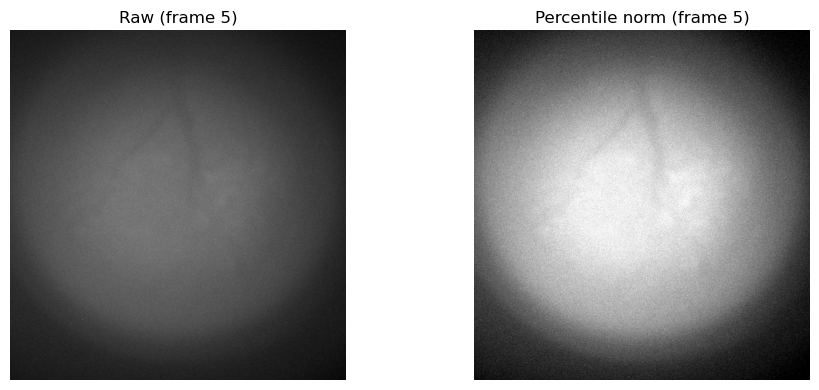

In [9]:
import matplotlib.pyplot as plt

t_show = min(5, (arr_raw.shape[0]-1))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].imshow(arr_raw[t_show], cmap="gray")
axs[0].set_title(f"Raw (frame {t_show})")
axs[0].axis("off")

axs[1].imshow(arr_norm[t_show], cmap="gray", vmin=0, vmax=1)
axs[1].set_title(f"Percentile norm (frame {t_show})")
axs[1].axis("off")
plt.tight_layout()
plt.show()


# 9) Summary assertions

A single place to fail fast if something went wrong above.


In [10]:
ref = mm if mm is not None else arr_raw
assert ref.shape == arr_auto.shape == arr_staged.shape, "Shapes mismatch among read modes"
assert np.allclose(np.asarray(arr_staged), np.asarray(ref)), "Staged read differs from reference"
assert np.allclose(np.asarray(read_back), np.asarray(ref)), "Orientation re-read differs"
assert np.allclose(np.asarray(mm_stream), np.asarray(ref)), "Stream-written file differs"

print("All I/O checks passed ✔️")


All I/O checks passed ✔️
